# Extracting contour lines

**Notebook currently compatible with both the `NCI` and `DEA Sandbox` environments**


### Background
[Contour extraction](https://en.wikipedia.org/wiki/Contour_line) is a fundamental image processing method used to detect and extract the boundaries of spatial features. While contour extraction has traditionally been used to precisely map lines of given elevation from digital elevation models (DEMs), contours can also be extracted from any other array-based data source. This can be used to support remote sensing applications where the position of a precise boundary needs to be mapped consistently over time, such as extracting dynamic waterline boundaries from satellite-derived Normalized Difference Water Index (NDWI) data.

### Description
This notebook demonstrates how to use the `contour_extract` function based on tools from `skimage.measure.find_contours` to:
1. Extract one or multiple contour lines from a single two-dimensional digital elevation model (DEM) and export these as a shapefile
2. Optionally include custom attributes in the extracted contour features
3. Load in a multi-dimensional satellite dataset from Digital Earth Australia, and extract a single contour value consistently through time along a specified dimension
4. Filter the resulting contours to remove small noisy features

### Technical details
* **Products used:** [`s2b_ard_granule`](http://explorer.sandbox.dea.ga.gov.au/s2b_ard_granule)
* **Analyses used:** Contour extraction, image processing, NDWI index, downloading data


## Getting started
To run this analysis, run all the cells in the notebook, starting with the "Load packages" cell. 

### Load packages

In [1]:
%matplotlib inline

import sys
import datacube
import numpy as np
import xarray as xr
import matplotlib as mpl
import matplotlib.pyplot as plt
from affine import Affine
from datacube.utils.geometry import CRS

sys.path.append('../Scripts')
from dea_datahandling import load_ard
from dea_datahandling import download_unzip
from dea_spatialtools import contour_extract
from dea_bandindices import calculate_indices


### Connect to the datacube

In [2]:
dc = datacube.Datacube(app='Contour_extraction')


## Load elevation data
To demonstrate contour extraction, we first need to obtain an elevation dataset. Here we download a tile of 90 m (3 arc seconds) resolution Shuttle Radar Topography Mission (SRTM) Digital Elevation Model (DEM) data for a region that includes Canberra using the `download_unzip` function from `dea_datahandling`. This data comes from the [CGIAR - Consortium for Spatial Information (CGIAR-CSI)](http://srtm.csi.cgiar.org/srtmdata/).

After we download the data, we load it in `xarray.open_rasterio` and modify the projection system and geotransform attributes so it is consistent was data loaded from Digital Earth Australia.

In [3]:
# Download and unzip the elevation data
download_unzip(url='http://srtm.csi.cgiar.org/wp-content/uploads/files/srtm_5x5/TIFF/srtm_66_20.zip')

# Read in the elevation data from file
elevation_array = xr.open_rasterio('srtm_66_20.tif').squeeze('band')

# Modify CRS and transform attributes into a format that is
# consistent with data loaded from `dc.load`
elevation_array.attrs['crs'] = CRS(elevation_array.crs[-9:])
elevation_array.attrs['transform'] = Affine(*elevation_array.transform)

# Print the data
print(elevation_array)

Unzipping output files to: /g/data1a/r78/rt1527/dea-notebooks/Frequently_used_code
<xarray.DataArray (y: 6000, x: 6000)>
[36000000 values with dtype=int16]
Coordinates:
    band     int64 1
  * y        (y) float64 -35.0 -35.0 -35.0 -35.0 ... -40.0 -40.0 -40.0 -40.0
  * x        (x) float64 145.0 145.0 145.0 145.0 ... 150.0 150.0 150.0 150.0
Attributes:
    transform:   | 0.00, 0.00, 145.00|\n| 0.00,-0.00,-35.00|\n| 0.00, 0.00, 1...
    crs:         epsg:4326
    res:         (0.0008333333333333334, 0.0008333333333333334)
    is_tiled:    0
    nodatavals:  (-32768.0,)
    scales:      (1.0,)
    offsets:     (0.0,)


We can plot a subset of the elevation data for a region around Canberra using a custom terrain-coloured colour map:

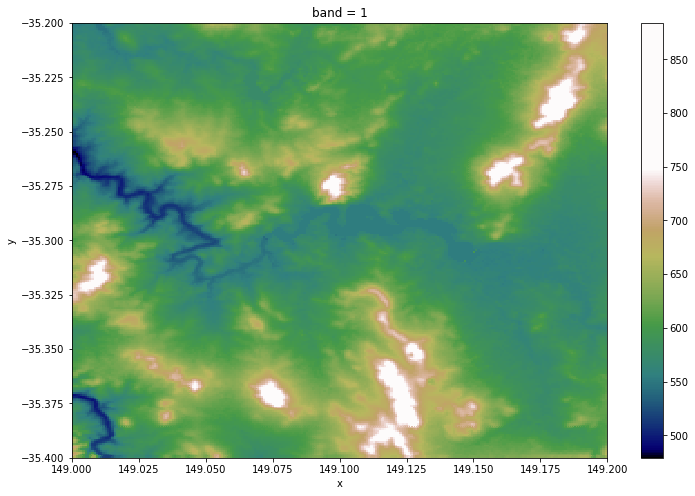

In [4]:
# Create a custom colourmap for the DEM
colors_terrain = plt.cm.gist_earth(np.linspace(0.0, 1.5, 100))
cmap_terrain = mpl.colors.LinearSegmentedColormap.from_list(
    'terrain', colors_terrain)

# Plot a subset of the elevation data
elevation_array.sel(x=slice(149.00, 149.20),
                    y=slice(-35.20, -35.40)).plot(size=8, cmap=cmap_terrain)


## Contour extraction in 'single array, multiple z-values' mode
The `dea_spatialtools.contour_extract` function uses `skimage.measure.find_contours` to extract contour lines from an array. This can be an elevation dataset like the data imported above, or any other two-dimensional or multi-dimensional array. We can extract contours from the elevation array imported above by providing a single z-value/elevation or a list of z-values/elevations. We also need to provide a `crs` and an `affine` object, both of which can be obtained from the xarray DataArray.

### Extracting a single contour
Here, we extract a single 600 m elevation contour:

In [5]:
# Extract contours
contour_gdf = contour_extract(z_values=600,
                              ds_array=elevation_array,
                              ds_crs=elevation_array.crs,
                              ds_affine=elevation_array.transform,
                              output_shp='extracted_contours.shp')

# Print output
contour_gdf

Operating in single array, multiple z-values mode
    Extracting contour 600
Exporting contour shapefile to extracted_contours.shp


,z_value,geometry
0,600.0,(LINESTRING (148.0301388888889 -35.00041666666...


This writes the shapefile to file, and returns a Geopandas geodataframe containing a single contour line feature with the z-value (i.e. elevation) given in a shapefile field named z_value. We can plot contour this for the Canberra subset:

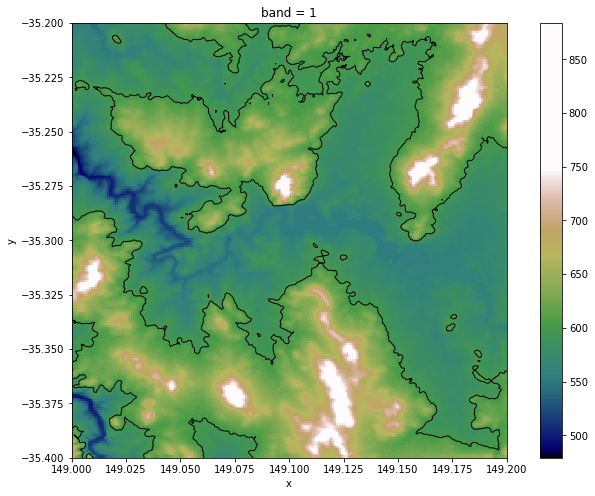

In [6]:
elevation_array.sel(x=slice(149.00, 149.20), 
                   y=slice(-35.20, -35.40)).plot(size=8, cmap=cmap_terrain)
contour_gdf.plot(ax=plt.gca(), linewidth=1.0, color='black')  


### Extracting multiple contours 
We can easily import multiple contours from a single array by supplying a list of z-values to extract. 
The function will then extract a contour for each value in `z_values`, skipping any contour elevation that is not found in the array.

Any number of contours can be extracted; for large numbers of contours, it can be useful to use the `verbose=False` parameter to prevent the `Extracting contour 700` text from being printed to the screen:

Operating in single array, multiple z-values mode
    Extracting contour 500
    Extracting contour 520
    Extracting contour 540
    Extracting contour 560
    Extracting contour 580
    Extracting contour 600
    Extracting contour 650
    Extracting contour 700
    Extracting contour 800
Exporting contour shapefile to extracted_contours.shp


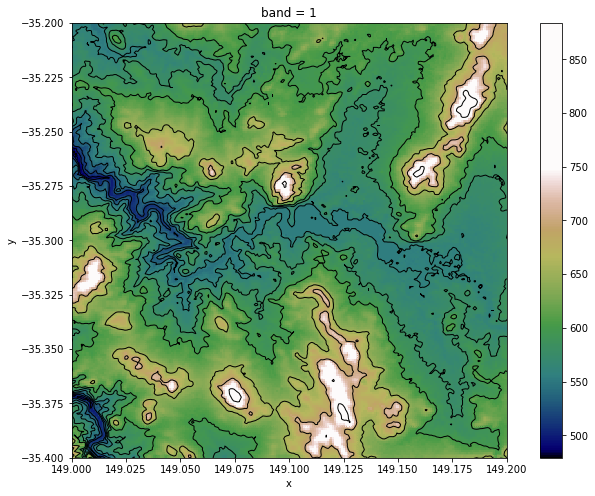

In [7]:
# List of elevations to extract
elev_list = [500, 520, 540, 560, 580, 600, 650, 700, 800]

# Extract contours
contour_gdf = contour_extract(z_values=elev_list,
                              ds_array=elevation_array,
                              ds_crs=elevation_array.crs,
                              ds_affine=elevation_array.transform,
                              output_shp='extracted_contours.shp')

# Plot extracted contours over the DEM
elevation_array.sel(x=slice(149.00, 149.20), 
                   y=slice(-35.20, -35.40)).plot(size=8, cmap=cmap_terrain)
contour_gdf.plot(ax=plt.gca(), linewidth=1.0, color='black')  

### Custom shapefile attributes
By default, the shapefile includes a single `z_value` attribute field with one feature per input value in `z_values`. We can instead pass custom attributes to the output
shapefile using the `attribute_data` and `attribute_dtypes` parameters. For example, we might want a custom column called `elev_cm` with heights in cm instead of m, and a `location` column giving the location (Canberra). 

We can achieve this by passing in a dict with field names as keys, and a list of values of the same length as `z_values`. When passing in custom attributes, we also need to manually set the dtypes for the output fields using an `attribute_dtypes` dictionary. The dict should have the same keys/field names as declared in `attribute_data`, and values which include `int`, `str`, `datetime`, and `float:X.Y`, where X is the minimum number of characters before the decimal place, and Y is the number of characters after the decimal place:

In [8]:
# Elevation values to extract
elev_values = [550, 600, 650, 700]

# Set up dicts with the attribute field name as the dict key, and lists 
# of values of the same length as `z_values`:
custom_attrs = {'elev_cm': [55000, 60000, 65000, 70000],
                'location': ['Canberra', 'Canberra', 'Canberra', 'Canberra']}
custom_attrs_dtypes = {'elev_cm': 'int', 'location': 'str'}

# Extract contours with custom attribute fields:
contour_gdf = contour_extract(z_values=elev_values,
                               ds_array=elevation_array,
                               ds_crs=elevation_array.crs,
                               ds_affine=elevation_array.transform,
                               output_shp='extracted_contours_attrs.shp',
                               attribute_data=custom_attrs,
                               attribute_dtypes=custom_attrs_dtypes)

# Print output
contour_gdf.head()

Operating in single array, multiple z-values mode
    Extracting contour 550
    Extracting contour 600
    Extracting contour 650
    Extracting contour 700
Exporting contour shapefile to extracted_contours_attrs.shp


,elev_cm,location,geometry
0,55000,Canberra,(LINESTRING (148.0408333333333 -35.00041666666...
1,60000,Canberra,(LINESTRING (148.0301388888889 -35.00041666666...
2,65000,Canberra,(LINESTRING (148.0379166666667 -35.00479166666...
3,70000,Canberra,"(LINESTRING (149.64625 -35.00041666666667, 149..."


## Contours from non-elevation datasets in in 'single z-value, multiple arrays' mode
As well as extracting multiple contours from a single two-dimensional array, `contour_extract` also allows you to extract a single z-value from every array along a specified dimension in a multi-dimensional array. This can be useful for comparing the changing topography of a landscape across time. The input multi-dimensional array does not need to be elevation data: contours can be extracted from any type of data. For example, we can use the function to extract the boundary between land and water. 

First, we will load in a time series of Sentinel 2 imagery and calculate a simple Normalized Difference Water Index (NDWI) on two images. This index will have high values where a pixel is likely to be open water (e.g. NDWI > 0, coloured in blue below):

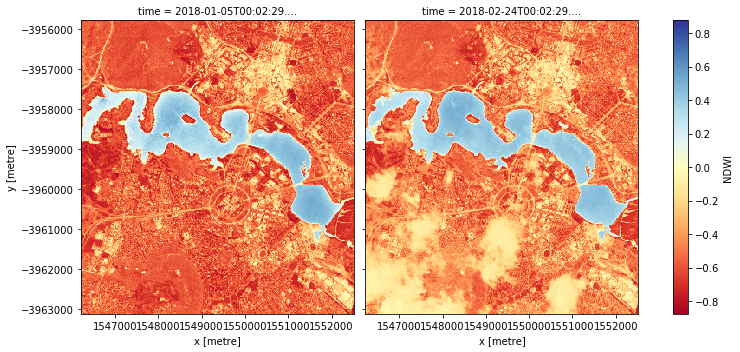

In [9]:
# Set up a datacube query to load data for
query = {
    'lat': (-35.27, -35.33),
    'lon': (149.09, 149.15),
    'time': ('2018-01-01', '2018-02-25'),
    'measurements': ['nbart_green', 'nbart_nir_1'],
    'output_crs': 'EPSG:3577',
    'resolution': (-20, 20)
}

# Load Sentinel 2 data
s2_ds = dc.load(product='s2b_ard_granule', group_by='solar_day', **query)

# Calculate NDWI on the first and last image in the dataset
s2_ndwi = calculate_indices(s2_ds.isel(time=[0, -1]),
                            index='NDWI',
                            collection='ga_s2_1')

# Plot the two images side by size
s2_ndwi.NDWI.plot(col='time', cmap='RdYlBu', size=5)


We can now identify the land-water boundary by extracting the 0 NDWI contour for each array in the dataset along the `time` dimension. By plotting the resulting contour lines for a zoomed in area, we can then start to compare phenomenon like lake levels across time:

Operating in single z-value, multiple arrays mode
    Extracting contour 0
    Extracting contour 1
Exporting contour shapefile to extracted_contours_ndwi.shp


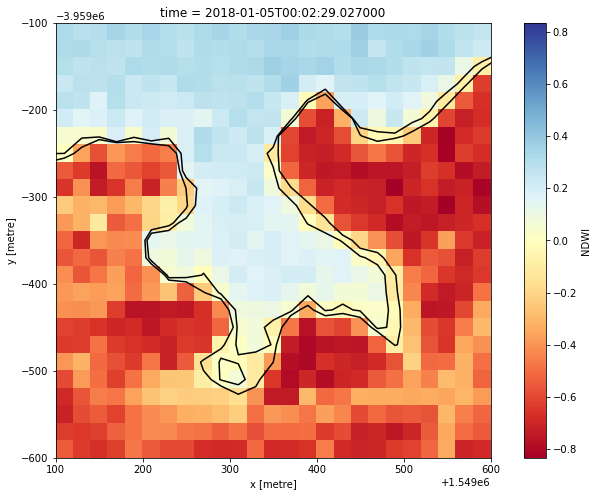

In [10]:
# Extract the 0 NDWI contour from both timesteps in the NDWI data
contour_gdf = contour_extract(z_values=0,
                              ds_array=s2_ndwi.NDWI,
                              ds_crs=s2_ndwi.geobox.crs,
                              ds_affine=s2_ndwi.geobox.affine,
                              output_shp='extracted_contours_ndwi.shp')

# Plot contours over the top of array
s2_ndwi.NDWI.sel(time='2018-01-05',
                 x=slice(1549100, 1549600),
                 y=slice(-3959100, -3959600)).plot(size=8, cmap='RdYlBu')
contour_gdf.plot(ax=plt.gca(), linewidth=1.5, color='black')


### Dropping small contours
Contours produced by `contour_extract` can include many small features. We can optionally choose to extract only contours larger than a certain number of vertices using the `min_vertices` parameter. This can be useful for focusing on large contours, and remove possible noise in a dataset. Here we set `min_vertices=20` to keep only contours with at least 20 vertices. Observe the small waterbody in the bottom-right of the image disappear:

Operating in single z-value, multiple arrays mode
    Extracting contour 0
    Extracting contour 1
Exporting contour shapefile to extracted_contours_ndwi.shp


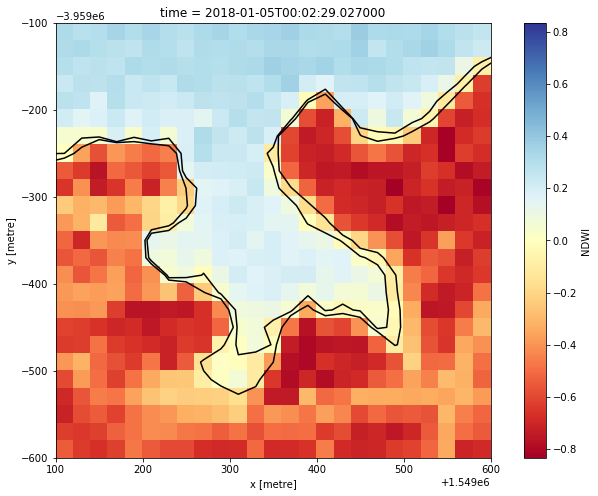

In [11]:
# Extract contours with custom attribute fields:
contour_gdf = contour_extract(z_values=0,
                              ds_array=s2_ndwi.NDWI,
                              ds_crs=s2_ndwi.geobox.crs,
                              ds_affine=s2_ndwi.geobox.affine,
                              output_shp='extracted_contours_ndwi.shp',
                              min_vertices=20)

# Plot contours over the top of array
s2_ndwi.NDWI.sel(time='2018-01-05',
            x=slice(1549100, 1549600),
            y=slice(-3959100, -3959600)).plot(size=8, cmap='RdYlBu')
contour_gdf.plot(ax=plt.gca(), linewidth=1.5, color='black')


## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Australia data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/GeoscienceAustralia/dea-notebooks).

**Last modified:** October 2019

**Compatible `datacube` version:** 

In [12]:
print(datacube.__version__)

1.7


## Tags
Browse all available tags on the DEA User Guide's [Tags Index](https://docs.dea.ga.gov.au/genindex.html)